# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [1]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload

import matplotlib.pyplot as plt

from time import perf_counter
import os
import sys

warnings.filterwarnings('ignore')

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))

In [3]:
import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import sn_plotting
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import plotting_functions
logger = utils.get_notebook_logger()

In [4]:
notebook_number='00'

In [29]:
client.close()

- Closing Nanny at 'tcp://127.0.0.1:45939'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Closing Nanny at 'tcp://127.0.0.1:45981'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Closing Nanny at 'tcp://127.0.0.1:45803'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Closing Nanny at 'tcp://127.0.0.1:37715'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Stopping worker at tcp://127.0.0.1:42253. Reason: nanny-close
- Closing Nanny at 'tcp://127.0.0.1:37533'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Closing Nanny at 'tcp://127.0.0.1:42921'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Stopping worker at tcp://127.0.0.1:43175. Reason: nanny-close
- Closing Nanny at 'tcp://127.0.0.1:42527'. Reason: nanny-close
- Nanny asking worker to close. Reason: nanny-close
- Remove client Client-worker-9481cf24-ec6d-11ed-af2c-000007

In [6]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:43759
-   dashboard at:         /proxy/8787/status
-         Start Nanny at: 'tcp://127.0.0.1:45939'
-         Start Nanny at: 'tcp://127.0.0.1:45981'
-         Start Nanny at: 'tcp://127.0.0.1:45803'
-         Start Nanny at: 'tcp://127.0.0.1:37715'
-         Start Nanny at: 'tcp://127.0.0.1:37533'
-         Start Nanny at: 'tcp://127.0.0.1:42921'
-         Start Nanny at: 'tcp://127.0.0.1:42527'
- Register worker <WorkerState 'tcp://127.0.0.1:45419', name: 5, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:45419
- Starting established connection to tcp://127.0.0.1:39580
- Register worker <WorkerState 'tcp://127.0.0.1:46695', name: 0, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46695
- Starting established connection to tcp://127.0.0.1:39618
- Register worker <WorkerState 'tcp://127.0.0.1:42253', name: 2, status: init, memory: 0, processing: 0>
- 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43759,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:46695,Total threads: 4
Dashboard: /proxy/36737/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:45939,


# Loading Data

In [7]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]

In [8]:
experiment_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'A1')).chunk('auto')
picontrol_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol')).chunk('auto')

- Event loop was unresponsive in Scheduler for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.60s.  This is often caused by long-r

In [10]:
experiment_zec_da

<xarray.DataArray (time: 100, model: 8, lat: 96, lon: 192)>
dask.array<rechunk-merge, shape=(100, 8, 96, 192), dtype=float32, chunksize=(100, 8, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model     (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height    float64 2.0
    variable  <U3 'tas'

# Calculation

In [11]:
trend_local_da = stats.trend_fit(experiment_zec_da.chunk({'time':-1}), method='polynomial', order=3)
detrended_local_da = experiment_zec_da - trend_local_da
detrended_local_da = detrended_local_da.persist().chunk('auto')

In [12]:
detrended_local_da

<xarray.DataArray (time: 100, model: 8, lat: 96, lon: 192)>
dask.array<sub, shape=(100, 8, 96, 192), dtype=float64, chunksize=(100, 8, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model     (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height    float64 2.0
    variable  <U3 'tas'

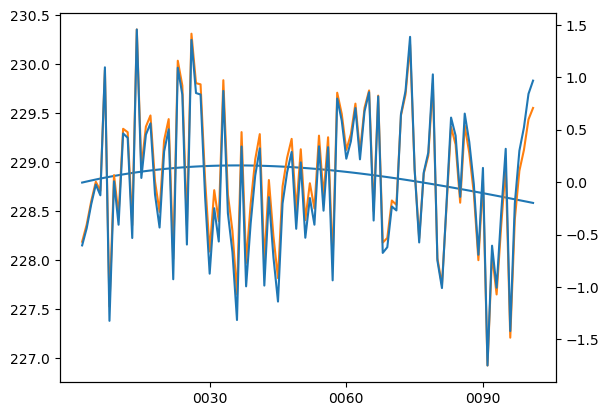

In [13]:
sel_kwargs = dict(model=0,lat=0, lon=0)

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(trend_local_da.isel(sel_kwargs).time.values, trend_local_da.isel(sel_kwargs).values)
ax.plot(experiment_zec_da.isel(sel_kwargs).time.values, experiment_zec_da.isel(sel_kwargs).values)

ax2.plot(detrended_local_da.isel(sel_kwargs).time.values, detrended_local_da.isel(sel_kwargs).values)

In [16]:
%%time
detrended_local_da = detrended_local_da.compute()#.persist().chunk('auto')
picontrol_zec_da = picontrol_zec_da.compute()#.persist().chunk('auto')
experiment_zec_da = experiment_zec_da.compute()#.persist().chunk('auto')

CPU times: user 153 ms, sys: 101 ms, total: 254 ms
Wall time: 391 ms


In [17]:
SAVE_DIR = os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'signal_to_noise'); SAVE_DIR

'/g/data/w40/ab2313/PhD/zecmip/regridded/signal_to_noise'

In [18]:
constants.ZECMIP_LOCAL_RUN_WINDOWS

[20, 40]

In [19]:
sn_exp_ds = sn.multiwindow_signal_to_noise(
    experiment_zec_da, rolling_noise=True, da_for_noise=detrended_local_da,
    logginglevel='ERROR', return_all=True, windows=constants.ZECMIP_LOCAL_RUN_WINDOWS).chunk('auto').persist()

20, 40, 
Concatenating objects - PLEASE be patient!


In [20]:
sn_control_ds = sn.multiwindow_signal_to_noise(
    picontrol_zec_da, rolling_noise=True, detrend=False,
    logginglevel='ERROR', return_all=True, windows=constants.ZECMIP_LOCAL_RUN_WINDOWS).chunk('auto').persist()

20, 40, 
Concatenating objects - PLEASE be patient!


In [21]:
sn_exp_ds.signal_to_noise

<xarray.DataArray 'signal_to_noise' (window: 2, time: 100, model: 8, lat: 96,
                                     lon: 192)>
dask.array<xarray-signal_to_noise, shape=(2, 100, 8, 96, 192), dtype=float64, chunksize=(2, 100, 8, 96, 109), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model     (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
  * window    (window) int64 20 40
    height    float64 2.0
    variable  <U3 'tas'

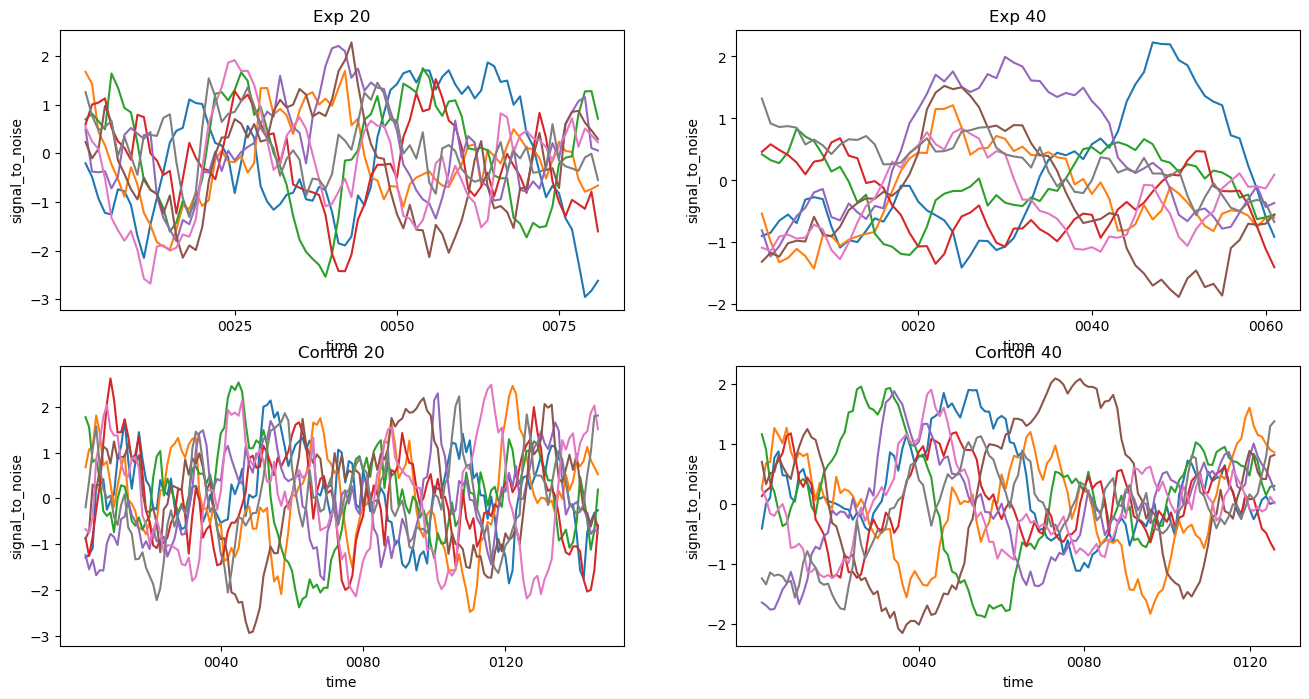

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8));
test_plot_kwargs = dict(x='time', hue='model', add_legend=False)
sn_exp_ds.signal_to_noise.sel(window=20).sel(lat=-38, lon=144, method='nearest').plot(ax=ax1, **test_plot_kwargs);
sn_exp_ds.signal_to_noise.sel(window=40).sel(lat=-38, lon=144, method='nearest').plot(ax=ax2, **test_plot_kwargs);

sn_control_ds.signal_to_noise.sel(window=20).sel(lat=-38, lon=144, method='nearest').plot(ax=ax3, **test_plot_kwargs);
sn_control_ds.signal_to_noise.sel(window=40).sel(lat=-38, lon=144, method='nearest').plot(ax=ax4, **test_plot_kwargs);

ax1.set_title('Exp 20'); ax2.set_title('Exp 40'); ax3.set_title('Control 20'); ax4.set_title('Contorl 40');

In [27]:
exp_save_name_and_path = os.path.join(SAVE_DIR, 'experiment_sn_window_20_40.nc'); print(exp_save_name_and_path)
sn_exp_ds.to_netcdf(exp_save_name_and_path)  

/g/data/w40/ab2313/PhD/zecmip/regridded/signal_to_noise/experiment_sn_window_20_40.nc


In [28]:
control_save_name_and_path = os.path.join(SAVE_DIR, 'control_sn_window_20_40.nc'); print(control_save_name_and_path)
sn_control_ds.to_netcdf(control_save_name_and_path)  

/g/data/w40/ab2313/PhD/zecmip/regridded/signal_to_noise/control_sn_window_20_40.nc


In [18]:
# already_saved = os.listdir(SAVE_DIR); already_saved
# rolling_noise_types = [True, False]
# data_dict = {'control':picontrol_zec_da, 'exp':experiment_zec_da}
# for dtype, ds in data_dict.items():
#     for rolling_noise in rolling_noise_types:
#         t1 = perf_counter()
#         print(f'{dtype=}, {rolling_noise=}')
#         save_name =  f'{dtype}_rolling_noise_{rolling_noise}.nc'
#         print(f' - File to save is {save_name}')

#         if save_name not in already_saved: # primitive way of controlling comoplete runs
#             print(' -  Running')
#             da_for_noise = detrended_local_da if dtype == 'exp' else ds
            
#             sn_ds = sn.multiwindow_signal_to_noise(
#             ds, rolling_noise=rolling_noise, da_for_noise=da_for_noise,
#                 logginglevel='ERROR', return_all=True, windows=constants.ZECMIP_LOCAL_RUN_WINDOWS)
            
#             sn_ds = sn_ds.persist()
#             save_name_and_path = os.path.join(SAVE_DIR, save_name); print(save_name_and_path)
#             sn_ds.to_netcdf(save_name_and_path)  
#         else:
#             print(' - Already run')
#         time_taken = perf_counter() - t1
#         print(f'{time_taken=}')
#         print('\n\n\n')